In [2]:
import numpy as np
import pandas as pd
import os 
import json 
import requests # library to handle requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing

import folium # map rendering library
print('Hello Capstone Project Course: Libraries loaded!')

Hello Capstone Project Course: Libraries loaded!


# Introduction

This report analyzes the surroundings of the [Metro de Santiago](https://www.metro.cl/)'s subway stations. For Metro, it is important to understand the behavior of its customers. Much of this behavior comes from the characteristics of the origin and destination of the trip, therefore describing the stations regarding the services and products of the surrounding environment can provide Metro with valuable information to understand certain indicators of demand.

The aim of this report will be to get information of the surrounding of each station from the Foursquare API, then with this data create clusters of stations that allows to summary the pattern observed in the data and finally visualize this results to conclude with the findings of the models.  

# Data

The data sets used for this analysis are:
- Station information: Station's identifier, geospatial information (latitude and longitude), line and route it belongs to.
- Surrounding information: The venues and categories of the surrounding that we get from Foursquare API.

We will transform the venues data set in a wide format that allows us to use each category like a feature, then we will calculate the representative percentage for each category and use it to define clusters of stations. 

# Methodology

### Loading and preprocessing

Let's load the stations data.

In [3]:
df_stations = pd.read_csv('data/metro_station.csv',sep=";", decimal=".")
df_stations.head()

,est_cod,linea,via,lon,lat,est_name
0,SP,L1,1,-70.723218,-33.445281,San Pablo
1,NP,L1,1,-70.722736,-33.451431,Neptuno
2,PJ,L1,1,-70.715469,-33.457532,Pajaritos
3,LR,L1,1,-70.706766,-33.457639,Las Rejas
4,EC,L1,1,-70.699733,-33.456026,Ecuador


In the data set each station have two samples to represent the differents direction of the rails that pass through them.  Let's  see how many unique stations we have.  

In [4]:
df_stations_unique = df_stations.drop_duplicates(subset=['est_name']).copy()
df_stations_unique.shape

(125, 6)

In [5]:
df_stations_unique.reset_index(drop = True, inplace = True)
df_stations_unique.rename(columns = {'est_name' : 'Station'}, inplace = True)

**With this data let's plot the stations on a map**. First let´s find the location of the center of the city (Santiago, Chile).

In [6]:
address = 'Santiago, Chile'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are -33.4377756, -70.6504502.


In [6]:
map_santiago = folium.Map(location=[latitude*1.001, longitude], zoom_start=11)

# add markers to map
for lat, lng, name in zip(df_stations_unique['lat'], df_stations_unique['lon'], df_stations_unique['Station']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_santiago)  
    
map_santiago

The next task is get the **venues's information from Foursquare API**. First let's define the credentials and version. For this i use local environmental variables for privacy with the library os.  

In [7]:
CLIENT_ID = os.getenv('foursquare_client_id') # your Foursquare ID
CLIENT_SECRET = os.getenv('foursquare_client_secret') # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Let's define a function that help us to obtain the venues from each stations.

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
metro_venues = getNearbyVenues(names=df_stations_unique['Station'],
                                   latitudes=df_stations_unique['lat'],
                                   longitudes=df_stations_unique['lon'])

San Pablo
Neptuno
Pajaritos
Las Rejas
Ecuador
San Alberto Hurtado
Universidad de Santiago
Estacion Central
Union Latinoamericana
Republica
Los Heroes
La Moneda
Universidad de Chile
Santa Lucia
Universidad Catolica
Baquedano
Salvador
Manuel Montt
Pedro de Valdivia
Los Leones
Tobalaba
El Golf
Alcantara
Escuela Militar
Manquehue
Hernando de Magallanes
Los Dominicos
Vespucio Norte
Zapadores
Dorsal
Einstein
Cementerios
Cerro Blanco
Patronato
Cal y Canto
Santa Ana
Toesca
Parque OHiggins
Rondizzoni
Franklin
El LLano
San Miguel
Lo Vial
Departamental
Ciudad del Nino
Lo Ovalle
El Parron
La Cisterna
Colon
Bilbao
Principe de Gales
Simon Bolivar
Plaza Egana
Los Orientales
Grecia
Los Presidentes
Quilin
Las Torres
Macul
Vicuna Mackenna
Vicente Valdes
Rojas Magallanes
Trinidad
San Jose de la Estrella
Los Quillayes
Elisa Correa
Hospital Sotero del Rio
Protectora de la Infancia
Las Mercedes
Plaza de Puente Alto
Santa Julia
La Granja
Santa Rosa
San Ramon
Plaza Maipu
Santiago Bueras
Del Sol
Monte Tabor
La

In [7]:
#metro_venues.to_csv('data/metro_venues2.csv')
metro_venues = pd.read_csv('data/metro_venues2.csv')
metro_venues.drop(metro_venues.columns[0], axis=1, inplace= True)
#metro_venues

In [8]:
metro_venues.groupby('Station').count().iloc[:,0:1].sort_values(by=['Station Latitude'])

,Station Latitude
Station,
La Granja,2
Gruta de Lourdes,2
Zapadores,4
Laguna Sur,4
Santa Julia,4
...,...
Santa Ana,85
Santa Lucia,91
La Moneda,92


In [11]:
print('There are {} uniques categories.'.format(len(metro_venues['Venue Category'].unique())))

There are 240 uniques categories.


In [10]:
metro_venues.loc[metro_venues['Venue Category'].str.contains('Restaurant', regex=False, na=False), 'Venue Category'] = 'Restaurant'
#metro_venues['Venue Category'].unique()
metro_venues = metro_venues[~metro_venues['Venue Category'].str.contains('Metro', na=False)]

In [12]:
metro_onehot = pd.get_dummies(metro_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
metro_onehot['Station'] = metro_venues['Station'] 

# move neighborhood column to the first column
fixed_columns = [metro_onehot.columns[-1]] + list(metro_onehot.columns[:-1])
metro_onehot = metro_onehot[fixed_columns]

metro_onehot.head()

,Station,Accessories Store,Adult Boutique,Airport,Amphitheater,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Travel Agency,Tree,Tunnel,Veterinarian,Video Game Store,Video Store,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,San Pablo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,San Pablo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,San Pablo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,San Pablo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,San Pablo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
metro_grouped = metro_onehot.groupby('Station').mean().reset_index()
#metro_grouped = metro_onehot.groupby('Station').sum().reset_index()
metro_grouped_clustering = metro_grouped.drop('Station', 1)

#prep_scaler = preprocessing.StandardScaler().fit(metro_grouped_clustering)
#prep_scaler = preprocessing.MinMaxScaler().fit(metro_grouped_clustering)
#X = prep_scaler.transform(metro_grouped_clustering)
X = metro_grouped_clustering

In [14]:
num_top_venues = 5

for hood in metro_grouped['Station']:
    print("----"+hood+"----")
    temp = metro_grouped[metro_grouped['Station'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agricola----
              venue  freq
0    Hardware Store   0.1
1    Sandwich Place   0.1
2             Motel   0.1
3  Football Stadium   0.1
4             Plaza   0.1


----Alcantara----
            venue  freq
0      Restaurant  0.21
1     Coffee Shop  0.16
2          Bakery  0.09
3        Pharmacy  0.07
4  Cosmetics Shop  0.07


----Baquedano----
            venue  freq
0      Restaurant  0.16
1            Café  0.07
2  Sandwich Place  0.07
3     Coffee Shop  0.07
4            Park  0.05


----Barrancas----
               venue  freq
0       Soccer Field  0.13
1  Food & Drink Shop  0.13
2         Restaurant  0.13
3               Food  0.07
4     Soccer Stadium  0.07


----Bellas Artes----
            venue  freq
0      Restaurant  0.22
1     Yoga Studio  0.04
2  Sandwich Place  0.04
3           Hotel  0.04
4       Bookstore  0.04


----Bilbao----
           venue  freq
0    Yoga Studio  0.10
1         Bakery  0.10
2  Deli / Bodega  0.10
3     Restaurant  0.10
4        Butcher  

         venue  freq
0   Restaurant  0.25
1  Pizza Place  0.09
2  Coffee Shop  0.09
3        Hotel  0.09
4    Bookstore  0.05


----Plaza Egana----
            venue  freq
0      Restaurant  0.27
1          Bakery  0.05
2     Coffee Shop  0.05
3  Clothing Store  0.04
4     Pizza Place  0.04


----Plaza Maipu----
            venue  freq
0      Restaurant  0.11
1     Pizza Place  0.11
2             Bar  0.09
3  Sandwich Place  0.09
4           Plaza  0.06


----Plaza de Armas----
        venue  freq
0  Restaurant  0.36
1   Bookstore  0.05
2    Pharmacy  0.03
3       Plaza  0.03
4        Café  0.03


----Plaza de Puente Alto----
               venue  freq
0         Restaurant  0.16
1              Diner  0.11
2             Bakery  0.05
3              Plaza  0.05
4  Convenience Store  0.05


----Presidente Pedro Aguirre Cerda----
                venue  freq
0                 Bar   0.2
1          Restaurant   0.2
2  Basketball Stadium   0.2
3        Soccer Field   0.2
4                 Pub  

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Station'] = metro_grouped['Station']

for ind in np.arange(metro_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(metro_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agricola,Hardware Store,Sandwich Place,Motel,Football Stadium,Plaza,Food Truck,Furniture / Home Store,Bakery,Cafeteria,BBQ Joint
1,Alcantara,Restaurant,Coffee Shop,Bakery,Pharmacy,Cosmetics Shop,Café,Plaza,Sandwich Place,Salad Place,Hotel
2,Baquedano,Restaurant,Café,Sandwich Place,Coffee Shop,Park,Plaza,Gift Shop,Hotel,Hostel,Rental Car Location
3,Barrancas,Soccer Field,Food & Drink Shop,Restaurant,Food,Soccer Stadium,Bus Station,Pizza Place,Speakeasy,Tunnel,Food Truck
4,Bellas Artes,Restaurant,Yoga Studio,Sandwich Place,Hotel,Bookstore,Coffee Shop,Café,Burger Joint,Hostel,Pizza Place


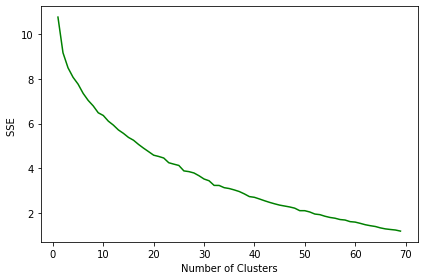

[10.76535973  9.1702377   8.49614635  8.07180589  7.76547702  7.35341608
  7.03812379  6.79274154  6.48425044  6.36402926  6.11040171  5.93327503
  5.71704796  5.56368545  5.38283566  5.25629321  5.06815514  4.90065735
  4.74513372  4.58717258  4.53042773  4.4608042   4.24935653  4.18655991
  4.12800066  3.88432622  3.85187265  3.79165903  3.66770154  3.52174335
  3.4426158   3.23588881  3.23295954  3.13355634  3.09542113  3.03333163
  2.9608754   2.85603312  2.73499468  2.7024883   2.62854957  2.54997814
  2.47679636  2.41256025  2.35371812  2.31228349  2.27105486  2.21720154
  2.10492179  2.10375429  2.04557581  1.95378922  1.92687006  1.85605604
  1.80143466  1.76731108  1.70827344  1.68614234  1.6139823   1.59383895
  1.53817479  1.47675041  1.43260975  1.3971879   1.33530541  1.28984909
  1.26286967  1.23913819  1.19072748]


In [18]:
Ks = 70
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))


for n in range(1,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)
    mean_acc[n-1] = kmeans.inertia_


plt.plot(range(1,Ks),mean_acc,'g')
plt.ylabel('SSE ')
plt.xlabel('Number of Clusters')
plt.tight_layout()
plt.show()

print(mean_acc)

In [19]:
deltas = [j-i for i, j in zip(mean_acc[:-1], mean_acc[1:])] ## 6 o 8 
deltas

[-1.5951220331785514,
 -0.6740913490830547,
 -0.4243404572968963,
 -0.3063288737436407,
 -0.41206094159643314,
 -0.31529228688974253,
 -0.24538225449479611,
 -0.3084910974443327,
 -0.12022117455063253,
 -0.2536275558952621,
 -0.17712668102334028,
 -0.21622706356794552,
 -0.15336251298584802,
 -0.18084978563310283,
 -0.12654245682316834,
 -0.18813806998419125,
 -0.16749778804540227,
 -0.15552362633039518,
 -0.1579611474426148,
 -0.0567448464521485,
 -0.069623529790376,
 -0.21144767354875071,
 -0.06279661386785662,
 -0.058559254696381124,
 -0.24367443876685835,
 -0.032453565113766736,
 -0.060213619386872086,
 -0.12395749736342854,
 -0.1459581900955116,
 -0.07912755080829026,
 -0.2067269861676042,
 -0.002929265784730628,
 -0.09940320048842644,
 -0.03813521838033518,
 -0.062089497668355254,
 -0.07245623188256056,
 -0.10484228009920882,
 -0.12103843079061782,
 -0.03250638922557458,
 -0.07393872784353794,
 -0.07857142857142829,
 -0.0731817750233299,
 -0.06423611111111072,
 -0.058842135915883

In [20]:
# set number of clusters
kclusters = 8
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([7, 4, 2, 6, 4, 2, 1, 2, 4, 5])

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

metro_merged = df_stations_unique
print(df_stations_unique.head())
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
metro_merged = metro_merged.join(neighborhoods_venues_sorted.set_index('Station'), on='Station')

metro_merged.head() # check the last columns!

  est_cod linea  via        lon        lat    Station
0      SP    L1    1 -70.723218 -33.445281  San Pablo
1      NP    L1    1 -70.722736 -33.451431    Neptuno
2      PJ    L1    1 -70.715469 -33.457532  Pajaritos
3      LR    L1    1 -70.706766 -33.457639  Las Rejas
4      EC    L1    1 -70.699733 -33.456026    Ecuador


,est_cod,linea,via,lon,lat,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,SP,L1,1,-70.723218,-33.445281,San Pablo,1,Restaurant,Pharmacy,Wings Joint,Convenience Store,Farmers Market,Bakery,Food Truck,Garden Center,Nightclub,Other Great Outdoors
1,NP,L1,1,-70.722736,-33.451431,Neptuno,0,Food Truck,Bus Station,Food Court,Park,Accessories Store,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife
2,PJ,L1,1,-70.715469,-33.457532,Pajaritos,0,Bus Station,Yoga Studio,Donut Shop,Moving Target,Coffee Shop,Health Food Store,Historic Site,Music Store,Park,Hot Dog Joint
3,LR,L1,1,-70.706766,-33.457639,Las Rejas,4,Restaurant,Bus Station,Gym,Pharmacy,Bakery,Burger Joint,Performing Arts Venue,Moving Target,Hot Dog Joint,Food Truck
4,EC,L1,1,-70.699733,-33.456026,Ecuador,1,Restaurant,Hot Dog Joint,Bakery,Food Truck,Convenience Store,Gym,Paper / Office Supplies Store,Performing Arts Venue,Pedestrian Plaza,Park


# Result and discussion

In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(metro_merged['lat'], metro_merged['lon'], metro_merged['Station'], metro_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [23]:
cluster_data =  neighborhoods_venues_sorted.iloc[:,0:2].join(metro_grouped.set_index('Station'), on='Station').copy()

cluster_data_mean = cluster_data.groupby('Cluster Labels').mean().reset_index()
cluster_data_median = cluster_data.groupby('Cluster Labels').median().reset_index()
cluster_data_q25 = cluster_data.groupby('Cluster Labels').quantile(.25).reset_index()
cluster_data_q75 = cluster_data.groupby('Cluster Labels').quantile(.75).reset_index()
cluster_data_std = cluster_data.groupby('Cluster Labels').std().reset_index()
cluster_data_name = cluster_data.groupby(['Cluster Labels'])['Station'].agg([('Stations', lambda Station: ' - '.join(Station))])

def clusterSummary(id):
    print(cluster_data_name.iloc[id,0])
    df_cluster1 = pd.concat([cluster_data_mean.reset_index(drop=True).iloc[id,1:], 
                         cluster_data_q25.iloc[id,1:], 
                         cluster_data_median.iloc[id,1:],
                         cluster_data_q75.iloc[id,1:],
                         cluster_data_std.iloc[id,1:]], axis=1)
    df_cluster1.columns = ['Mean', 'Qtl 0.25', 'Median', 'Qtl 0.75', 'Stand. Desv.']
    df_cluster1.sort_values(by=['Mean'], ascending=False,inplace = True)
    return(df_cluster1.reset_index().loc[0:10,:])

## Cluster 1

In [24]:
clusterSummary(0)

Cementerios - Cerrillos - Del Sol - LOS LIBERTADORES - Las Torres - Macul - Neptuno - Pajaritos - Protectora de la Infancia - San Alberto Hurtado - Santa Rosa - Vespucio Norte


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Bus Station,0.227080,0.17402,0.225000,0.250000,0.080951
1,Restaurant,0.086404,0.00000,0.079412,0.143939,0.089630
2,Park,0.056291,0.00000,0.000000,0.085784,0.093281
3,Pharmacy,0.054144,0.00000,0.000000,0.085227,0.081891
4,Food Truck,0.045139,0.00000,0.000000,0.031250,0.086051
5,Bakery,0.040530,0.00000,0.000000,0.087500,0.062961
6,Dessert Shop,0.038235,0.00000,0.000000,0.014706,0.077411
7,Hot Dog Joint,0.032680,0.00000,0.000000,0.014706,0.064808
8,Furniture / Home Store,0.030556,0.00000,0.000000,0.000000,0.071715
9,Grocery Store,0.023611,0.00000,0.000000,0.000000,0.060494


## Cluster 2

In [25]:
clusterSummary(1)

Bio Bio - Departamental - Ecuador - El LLano - Elisa Correa - Franklin - Gruta de Lourdes - HOSPITALES - Laguna Sur - Las Parcelas - Lo Ovalle - Lo Vial - Los Presidentes - M.EYZAGUIRRE - Monte Tabor - PLAZA ALMAGRO - PLAZA CHACABUCO - Patronato - Plaza de Armas - Rojas Magallanes - Salvador - San Miguel - San Pablo - Trinidad - Vicente Valdes - Zapadores


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Restaurant,0.405022,0.37282,0.400000,0.425595,0.050729
1,Pharmacy,0.054362,0.00000,0.037241,0.073317,0.067696
2,Bakery,0.036492,0.00000,0.000000,0.048864,0.061042
3,Park,0.031095,0.00000,0.000000,0.000000,0.099835
4,Food Truck,0.026842,0.00000,0.000000,0.030000,0.057517
5,Farmers Market,0.026363,0.00000,0.000000,0.041810,0.054802
6,Plaza,0.026030,0.00000,0.000000,0.044960,0.041447
7,Soccer Field,0.020055,0.00000,0.000000,0.000000,0.062336
8,Pizza Place,0.018740,0.00000,0.000000,0.030000,0.035820
9,Gym,0.013028,0.00000,0.000000,0.000000,0.030505


## Cluster 3

In [26]:
clusterSummary(2)

Baquedano - Bilbao - Blanqueado - Cerro Blanco - Colon - Dorsal - Einstein - Estacion Central - Estadio Nacional - Grecia - Ines de Suarez - La Florida - Los Orientales - MATTA - Manquehue - Mirador - Parque OHiggins - Pedrero - Plaza Maipu - Plaza de Puente Alto - Principe de Gales - Pudahuel - Quilin - San Joaquin - Simon Bolivar - Tobalaba - Universidad Catolica - Universidad de Santiago - VIVACETA - Vicuna Mackenna


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Restaurant,0.136894,0.116368,0.139610,0.160740,0.048428
1,Pharmacy,0.084369,0.000000,0.054887,0.095308,0.105733
2,Bakery,0.040840,0.000000,0.000000,0.051669,0.070431
3,Sandwich Place,0.034460,0.000000,0.026688,0.066667,0.038026
4,Gym,0.029566,0.000000,0.005882,0.035024,0.048905
5,Pizza Place,0.028644,0.000000,0.013129,0.051669,0.036802
6,Grocery Store,0.026036,0.000000,0.000000,0.017045,0.059634
7,Coffee Shop,0.019894,0.000000,0.000000,0.027679,0.028872
8,Bar,0.016643,0.000000,0.000000,0.027421,0.030687
9,Ice Cream Shop,0.016499,0.000000,0.000000,0.024432,0.029035


## Cluster 4

In [27]:
clusterSummary(3)

La Granja


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Music Venue,0.5,0.5,0.5,0.5,NaN
1,Shopping Mall,0.5,0.5,0.5,0.5,NaN
2,Accessories Store,0.0,0.0,0.0,0.0,NaN
3,Nightclub,0.0,0.0,0.0,0.0,NaN
4,Noodle House,0.0,0.0,0.0,0.0,NaN
5,Office,0.0,0.0,0.0,0.0,NaN
6,Optical Shop,0.0,0.0,0.0,0.0,NaN
7,Organic Grocery,0.0,0.0,0.0,0.0,NaN
8,Other Great Outdoors,0.0,0.0,0.0,0.0,NaN
9,Other Nightlife,0.0,0.0,0.0,0.0,NaN


## Cluster 5

In [28]:
clusterSummary(4)

Alcantara - Bellas Artes - CAL Y CANTO - CHILE-ESPANA - CONCHALI - Cal y Canto - Ciudad del Nino - DIAGONAL ORIENTE - El Golf - El Parron - Escuela Militar - FERNANDO CASTILLO VELASCO - Hernando de Magallanes - IRARRAZAVAL - Irarrazaval - La Cisterna - La Moneda - Las Mercedes - Las Rejas - Los Dominicos - Los Heroes - Los Leones - Los Quillayes - Manuel Montt - NUNOA - Nuble - Nunoa - PLAZA DE ARMAS - PLAZA EGANA - Parque Bustamante - Pedro de Valdivia - Plaza Egana - Presidente Pedro Aguirre Cerda - Quinta Normal - Republica - Ricardo Cumming - Rodrigo de Araya - Rondizzoni - San Jose de la Estrella - Santa Ana - Santa Isabel - Santa Lucia - Santiago Bueras - Toesca - U.DE CHILE - Union Latinoamericana - Universidad de Chile


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Restaurant,0.269116,0.231456,0.272727,0.304073,0.046701
1,Bar,0.035700,0.000000,0.022727,0.052778,0.045367
2,Bakery,0.035510,0.005495,0.022727,0.053571,0.034277
3,Pizza Place,0.033383,0.000000,0.032967,0.050000,0.034494
4,Coffee Shop,0.033352,0.000000,0.027027,0.051286,0.036849
5,Sandwich Place,0.030870,0.000000,0.022727,0.050424,0.031376
6,Pharmacy,0.028291,0.000000,0.013158,0.049754,0.035593
7,Café,0.023181,0.000000,0.011765,0.038462,0.029115
8,Plaza,0.021571,0.000000,0.016949,0.032866,0.024839
9,Burger Joint,0.020149,0.000000,0.016949,0.027212,0.027556


## Cluster 6

In [29]:
clusterSummary(5)

CARDENAL CARO - Hospital Sotero del Rio


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Plaza,0.380952,0.357143,0.380952,0.404762,0.067344
1,Soccer Field,0.154762,0.148810,0.154762,0.160714,0.016836
2,Food Truck,0.154762,0.148810,0.154762,0.160714,0.016836
3,Farmers Market,0.083333,0.041667,0.083333,0.125000,0.117851
4,Park,0.083333,0.041667,0.083333,0.125000,0.117851
5,Restaurant,0.071429,0.035714,0.071429,0.107143,0.101015
6,Convenience Store,0.071429,0.035714,0.071429,0.107143,0.101015
7,Organic Grocery,0.000000,0.000000,0.000000,0.000000,0.000000
8,Pet Service,0.000000,0.000000,0.000000,0.000000,0.000000
9,Other Great Outdoors,0.000000,0.000000,0.000000,0.000000,0.000000


## Cluster 7 

In [30]:
clusterSummary(6)

Barrancas - Lo Prado - Lo Valledor - San Ramon - Santa Julia


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Food Truck,0.141905,0.066667,0.142857,0.250000,0.110869
1,Soccer Field,0.106667,0.000000,0.000000,0.133333,0.173845
2,Department Store,0.068571,0.000000,0.000000,0.142857,0.096044
3,Soccer Stadium,0.063333,0.000000,0.000000,0.066667,0.108269
4,Food & Drink Shop,0.055238,0.000000,0.000000,0.133333,0.075713
5,Train Station,0.050000,0.000000,0.000000,0.000000,0.111803
6,Grocery Store,0.050000,0.000000,0.000000,0.000000,0.111803
7,Food Court,0.050000,0.000000,0.000000,0.000000,0.111803
8,Snack Place,0.050000,0.000000,0.000000,0.000000,0.111803
9,Liquor Store,0.050000,0.000000,0.000000,0.000000,0.111803


## Cluster 8

In [31]:
clusterSummary(7)

Agricola - Carlos Valdovino


,index,Mean,Qtl 0.25,Median,Qtl 0.75,Stand. Desv.
0,Cafeteria,0.192857,0.146429,0.192857,0.239286,0.131320
1,Furniture / Home Store,0.121429,0.110714,0.121429,0.132143,0.030305
2,Football Stadium,0.121429,0.110714,0.121429,0.132143,0.030305
3,Food Truck,0.121429,0.110714,0.121429,0.132143,0.030305
4,Auto Garage,0.071429,0.035714,0.071429,0.107143,0.101015
5,Supermarket,0.071429,0.035714,0.071429,0.107143,0.101015
6,Hardware Store,0.050000,0.025000,0.050000,0.075000,0.070711
7,Sandwich Place,0.050000,0.025000,0.050000,0.075000,0.070711
8,Bakery,0.050000,0.025000,0.050000,0.075000,0.070711
9,BBQ Joint,0.050000,0.025000,0.050000,0.075000,0.070711


In [113]:
metro_merged.loc[metro_merged['Cluster Labels'] == 0, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,L1,Neptuno,0,Bus Station,Garden Center,Farmers Market,Accessories Store,Pet Store,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife
2,L1,Pajaritos,0,Bus Station,Restaurant,Yoga Studio,Ice Cream Shop,Health Food Store,Historic Site,Park,Electronics Store,Donut Shop,Breakfast Spot
3,L1,Las Rejas,0,Restaurant,Pharmacy,Bakery,Gym,Food Truck,Performing Arts Venue,Hot Dog Joint,Sculpture Garden,Residential Building (Apartment / Condo),Burger Joint
4,L1,Ecuador,0,Restaurant,Food Truck,Breakfast Spot,Gym,Bakery,Convenience Store,Hot Dog Joint,Paper / Office Supplies Store,Performing Arts Venue,Pedestrian Plaza
5,L1,San Alberto Hurtado,0,Bakery,Restaurant,Bus Station,Pharmacy,Pizza Place,Hotel,Snack Place,Café,Beer Store,Fried Chicken Joint
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,L3,VIVACETA,0,Pharmacy,Restaurant,Gym,Grocery Store,Athletics & Sports,Accessories Store,Other Repair Shop,Park,Paper / Office Supplies Store,Other Nightlife
121,L3,CONCHALI,0,Restaurant,Cupcake Shop,Bus Station,Pharmacy,Park,Track Stadium,Sandwich Place,Pizza Place,Playground,Pub
122,L3,PLAZA CHACABUCO,0,Restaurant,Plaza,Racecourse,Soccer Stadium,Gym / Fitness Center,Pub,Office,Noodle House,Performing Arts Venue,Organic Grocery
128,L3,MATTA,0,Food Truck,Music Venue,Flea Market,Sporting Goods Shop,Gym,Photography Studio,Bistro,Food & Drink Shop,Restaurant,Indie Theater


In [114]:
metro_merged.loc[metro_merged['Cluster Labels'] == 1, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,L1,Los Leones,1,Restaurant,Clothing Store,Burger Joint,Bookstore,Café,Hotel,Coffee Shop,Sandwich Place,Ice Cream Shop,Hobby Shop
20,L1,Tobalaba,1,Restaurant,Hotel,Clothing Store,Coffee Shop,Burger Joint,Ice Cream Shop,Café,Gourmet Shop,Bakery,Candy Store
35,L2,Santa Ana,1,Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Bakery,Bar,Plaza,History Museum,Burger Joint,Park
49,L4,Tobalaba,1,Restaurant,Hotel,Clothing Store,Coffee Shop,Burger Joint,Ice Cream Shop,Café,Gourmet Shop,Bakery,Candy Store
92,L5,Santa Ana,1,Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Bakery,Bar,Plaza,History Museum,Burger Joint,Park
117,L6,Los Leones,1,Restaurant,Clothing Store,Burger Joint,Bookstore,Café,Hotel,Coffee Shop,Sandwich Place,Ice Cream Shop,Hobby Shop


In [115]:
metro_merged.loc[metro_merged['Cluster Labels'] == 2, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,L1,Republica,2,Restaurant,Bar,Pizza Place,Café,Pub,Hostel,Burrito Place,Diner,Plaza,Martial Arts School
10,L1,Los Heroes,2,Restaurant,Café,Bar,Sandwich Place,Yoga Studio,Hot Dog Joint,Gym,Coffee Shop,Bookstore,Other Nightlife
11,L1,La Moneda,2,Restaurant,Café,Plaza,Coffee Shop,Bookstore,Gym,Bakery,Theater,Diner,Bar
13,L1,Santa Lucia,2,Restaurant,Coffee Shop,Sandwich Place,Bookstore,Hotel,Pizza Place,Yoga Studio,Snack Place,Breakfast Spot,Hostel
15,L1,Baquedano,2,Restaurant,Coffee Shop,Sandwich Place,Hostel,Plaza,Café,Theater,Bar,Hotel,Snack Place
16,L1,Salvador,2,Restaurant,Bar,Café,Plaza,Pub,Park,Spa,Hostel,Hobby Shop,Theater
17,L1,Manuel Montt,2,Restaurant,Café,Coffee Shop,Pizza Place,Sandwich Place,Bar,Gastropub,Hotel,Burger Joint,Hostel
21,L1,El Golf,2,Restaurant,Coffee Shop,Café,Bakery,Hotel,Sandwich Place,Salad Place,Deli / Bodega,Cosmetics Shop,Cocktail Bar
36,L2,Los Heroes,2,Restaurant,Café,Bar,Sandwich Place,Yoga Studio,Hot Dog Joint,Gym,Coffee Shop,Bookstore,Other Nightlife
61,L4,Vicuna Mackenna,2,Restaurant,Ice Cream Shop,Cosmetics Shop,Sporting Goods Shop,Café,Pharmacy,Bar,Sandwich Place,Arcade,Pub


In [116]:
metro_merged.loc[metro_merged['Cluster Labels'] == 3, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,L1,San Pablo,3,Restaurant,Pharmacy,Garden Center,Convenience Store,Nightclub,Food Truck,Bakery,Farmers Market,Wings Joint,Pool
7,L1,Estacion Central,3,Restaurant,Pharmacy,Sandwich Place,Shopping Mall,Hotel,Fried Chicken Joint,Pizza Place,Burger Joint,Café,Sporting Goods Shop
8,L1,Union Latinoamericana,3,Restaurant,Hotel,Business Service,Shopping Mall,Café,Martial Arts School,Bakery,Fried Chicken Joint,Food Truck,Coffee Shop
12,L1,Universidad de Chile,3,Restaurant,Bookstore,Candy Store,Café,Shopping Mall,Theater,Coffee Shop,Pizza Place,Plaza,Dessert Shop
18,L1,Pedro de Valdivia,3,Restaurant,Hotel,Pizza Place,Coffee Shop,Bookstore,Yoga Studio,Electronics Store,Burger Joint,Shopping Mall,Sandwich Place
22,L1,Alcantara,3,Restaurant,Coffee Shop,Bakery,Pharmacy,Cosmetics Shop,Café,Plaza,Sandwich Place,Hotel,Salad Place
23,L1,Escuela Militar,3,Restaurant,Coffee Shop,Pharmacy,Café,Sandwich Place,Plaza,Bakery,Pizza Place,Creperie,Hotel
25,L1,Hernando de Magallanes,3,Restaurant,Bakery,Sandwich Place,Pool,Pharmacy,Cocktail Bar,Coffee Shop,Café,Playground,Plaza
26,L1,Los Dominicos,3,Restaurant,Arts & Crafts Store,Bus Station,Pharmacy,Pizza Place,Bus Line,Park,Skating Rink,Grocery Store,Shopping Mall
33,L2,Patronato,3,Restaurant,Farmers Market,Cheese Shop,Snack Place,Café,Gift Shop,Deli / Bodega,Candy Store,Clothing Store,Grocery Store


In [117]:
metro_merged.loc[metro_merged['Cluster Labels'] == 4, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [102]:
metro_merged.loc[metro_merged['Cluster Labels'] == 5, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,L1,San Pablo,5,Restaurant,Pharmacy,Garden Center,Convenience Store,Nightclub,Food Truck,Bakery,Farmers Market,Wings Joint,Pool
3,L1,Las Rejas,5,Restaurant,Pharmacy,Bakery,Gym,Food Truck,Performing Arts Venue,Hot Dog Joint,Sculpture Garden,Residential Building (Apartment / Condo),Burger Joint
6,L1,Universidad de Santiago,5,Restaurant,Pizza Place,Pharmacy,Bakery,Sandwich Place,Coffee Shop,Fried Chicken Joint,Snack Place,Park,Food & Drink Shop
7,L1,Estacion Central,5,Restaurant,Pharmacy,Sandwich Place,Shopping Mall,Hotel,Fried Chicken Joint,Pizza Place,Burger Joint,Café,Sporting Goods Shop
8,L1,Union Latinoamericana,5,Restaurant,Hotel,Business Service,Shopping Mall,Café,Martial Arts School,Bakery,Fried Chicken Joint,Food Truck,Coffee Shop
18,L1,Pedro de Valdivia,5,Restaurant,Hotel,Pizza Place,Coffee Shop,Bookstore,Yoga Studio,Electronics Store,Burger Joint,Shopping Mall,Sandwich Place
25,L1,Hernando de Magallanes,5,Restaurant,Bakery,Sandwich Place,Pool,Pharmacy,Cocktail Bar,Coffee Shop,Café,Playground,Plaza
26,L1,Los Dominicos,5,Restaurant,Arts & Crafts Store,Bus Station,Pharmacy,Pizza Place,Bus Line,Park,Skating Rink,Grocery Store,Shopping Mall
37,L2,Toesca,5,Restaurant,Hot Dog Joint,Deli / Bodega,Gym,Coffee Shop,Pizza Place,Building,Gastropub,Park,Gym / Fitness Center
41,L2,El LLano,5,Restaurant,Sports Club,Park,Breakfast Spot,Plaza,Soccer Stadium,Nightclub,Supermarket,Shopping Mall,Gym


In [104]:
metro_merged.loc[metro_merged['Cluster Labels'] == 6, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,L1,Los Heroes,6,Restaurant,Café,Bar,Sandwich Place,Yoga Studio,Hot Dog Joint,Gym,Coffee Shop,Bookstore,Other Nightlife
12,L1,Universidad de Chile,6,Restaurant,Bookstore,Candy Store,Café,Shopping Mall,Theater,Coffee Shop,Pizza Place,Plaza,Dessert Shop
23,L1,Escuela Militar,6,Restaurant,Coffee Shop,Pharmacy,Café,Sandwich Place,Plaza,Bakery,Pizza Place,Creperie,Hotel
33,L2,Patronato,6,Restaurant,Farmers Market,Cheese Shop,Snack Place,Café,Gift Shop,Deli / Bodega,Candy Store,Clothing Store,Grocery Store
34,L2,Cal y Canto,6,Restaurant,Farmers Market,Diner,Juice Bar,History Museum,Accessories Store,Furniture / Home Store,Bookstore,Boutique,Gym Pool
36,L2,Los Heroes,6,Restaurant,Café,Bar,Sandwich Place,Yoga Studio,Hot Dog Joint,Gym,Coffee Shop,Bookstore,Other Nightlife
40,L2,Franklin,6,Restaurant,Bakery,Nightclub,Theater,Gym,Pharmacy,Martial Arts School,Flea Market,Plaza,Other Great Outdoors
54,L4,Plaza Egana,6,Restaurant,Coffee Shop,Bakery,Clothing Store,Electronics Store,Multiplex,Pizza Place,Fried Chicken Joint,Ice Cream Shop,Liquor Store
93,L5,Plaza de Armas,6,Restaurant,Bookstore,Pharmacy,Café,Arts & Crafts Store,Plaza,Convenience Store,Theater,History Museum,Historic Site
94,L5,Bellas Artes,6,Restaurant,Yoga Studio,Café,Sandwich Place,Bookstore,Art Museum,Coffee Shop,Burger Joint,Hostel,Theater


In [105]:
metro_merged.loc[metro_merged['Cluster Labels'] == 7, metro_merged.columns[[1] + list(range(5, metro_merged.shape[1]))]]

,linea,Station,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,L2,Santa Ana,7,Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Bakery,Bar,Plaza,History Museum,Burger Joint,Park
92,L5,Santa Ana,7,Restaurant,Coffee Shop,Pizza Place,Sandwich Place,Bakery,Bar,Plaza,History Museum,Burger Joint,Park


# Conclusion